# Section 6: Non-deterministic Components

In [1]:
import sys
sys.path.append("../postbound/postbound")

In [2]:
import json

from matplotlib import ticker
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from postbound.db import postgres
from postbound.experiments import workloads

In [3]:
results_base = "../datasets/03-non-deterministic"
static_results_base = "../datasets/00-base"
workloads.workloads_base_dir = "../postbound/workloads"
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42
sns.set_style("whitegrid")
sns.set_context("talk")

In [4]:
def read_df(path: str, workload: workloads.Workload[str]) -> pd.DataFrame:
    geqo_thresh = 12
    df = pd.read_csv(path, converters={"query_result": json.loads})
    df = df.query("server == 'ssd'").copy()
    df["label"] = pd.Categorical(df["label"], categories=workload.labels(), ordered=True)
    df["query_plan"] = df["query_result"].apply(postgres.PostgresExplainPlan)
    df["plan_hash"] = df["query_plan"].apply(hash)
    df["triggers_geqo"] = df["label"].apply(lambda label: len(workload[label].tables()) >= geqo_thresh)
    return df


def plans_per_query(df: pd.DataFrame) -> pd.DataFrame:
    raw_ppq = (df
               .groupby(["label", "geqo", "triggers_geqo"], as_index=False, observed=True)
               .agg(n_plans=pd.NamedAgg(column="plan_hash", aggfunc=lambda plans: len(set(plans))),
                    min_rt=pd.NamedAgg(column="exec_time", aggfunc="min"),
                    max_rt=pd.NamedAgg(column="exec_time", aggfunc="max")))

    ppq = (raw_ppq
           .merge(raw_ppq.query("geqo == 'on'")[["label", "n_plans"]],
                  on="label", how="left", suffixes=("", "_geqo"))
           .fillna({"n_plans_geqo": 1})
           .assign(n_plans=lambda df: np.where(~df["triggers_geqo"],
                                               np.max([df["n_plans"], df["n_plans_geqo"]], axis=0),
                                               df["n_plans"]))
           .drop(columns="n_plans_geqo")
           .fillna({"n_plans": 1}))

    return ppq


## JOB Analysis

In [5]:
job = workloads.job()
df_job = read_df(f"{results_base}/analyze-stability-job.csv", job)

In [6]:
job_ppq = plans_per_query(df_job)

### Figure 10: Influence of non-deterministic optimizer components on selected plans

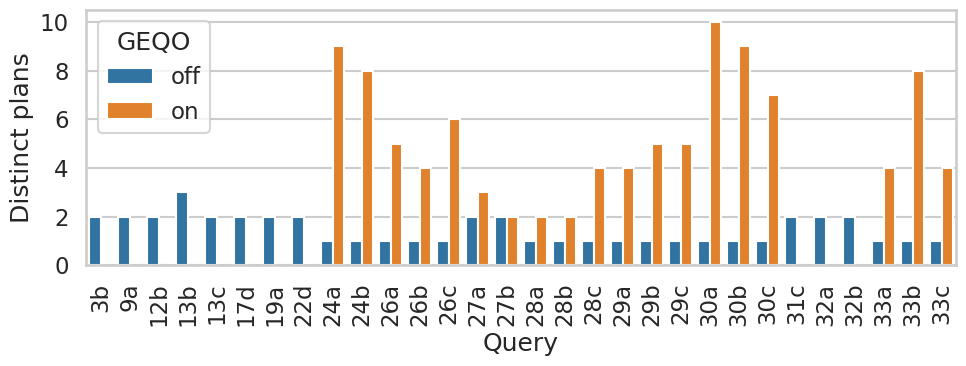

In [7]:
changing_plans = (job_ppq
                  .query("n_plans > 1")
                  .pivot(columns="geqo", index="label", values="n_plans")
                  .reset_index()
                  .fillna({"off": 1.0, "on": 1.0})
                  .assign(on=lambda df: np.where(df["label"].map(lambda label: len(job[label].tables()) >= 12), df["on"], np.nan))
                  .melt(id_vars="label", var_name="geqo", value_name="n_plans"))

g = sns.barplot(changing_plans, x="label", y="n_plans", hue="geqo",
                order=changing_plans["label"].unique())  # restrict to the labels that are actually present
g.tick_params(axis='x', rotation=90)
g.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
g.set(xlabel="Query", ylabel="Distinct plans")
g.legend(title="GEQO")
fig = g.get_figure()
fig.tight_layout()
fig.savefig("plots/job-plan-stability.pdf")

### Numbers used throughout the text

**Ratio of stable queries (no plan changes):**

In [8]:
1.0 - len(job_ppq.query("n_plans > 1")["label"].unique()) / len(job)

0.7345132743362832

**Ratio of queries that are not optimized by GEQO:**

In [9]:
job_ppq["triggers_geqo"].sum() / (2*len(job))

np.float64(0.17699115044247787)

**Number of queries that change their plans:**

In [10]:
(job_ppq
 .query("n_plans > 1")
 .groupby("geqo", as_index=False, observed=True)
 ["n_plans"]
 .count()
 .rename(columns={"n_plans": "n_queries"}))

,geqo,n_queries
0,off,13
1,on,30


**Maximum number of plan changes of a single query:**

In [11]:
job_ppq.loc[job_ppq["n_plans"].idxmax()]

label                 30a
geqo                   on
triggers_geqo        True
n_plans                10
min_rt           2.177411
max_rt           3.362547
Name: 205, dtype: object

**Runtime increase for changing queries without GEQO:**

In [12]:
job_ppq.query("geqo == 'off' & n_plans > 1").set_index("label")[["min_rt", "max_rt"]].sum()

min_rt    24.399729
max_rt    66.280299
dtype: float64

**Runtime increase for changing queries with GEQO:**

In [13]:
job_ppq.query("geqo == 'on' & n_plans > 1").set_index("label")[["min_rt", "max_rt"]].sum()

min_rt     54.021355
max_rt    105.508865
dtype: float64

## Stats Analysis

In [14]:
stats = workloads.stats()
df_stats = read_df(f"{results_base}/analyze-stability-stats.csv", stats)

**There are no plan changes on Stats:**

In [15]:
(df_stats
 .groupby(["label", "geqo", "triggers_geqo"], as_index=False, observed=True)
 .agg(n_plans=pd.NamedAgg(column="plan_hash", aggfunc=lambda plans: len(set(plans))))
 .query("n_plans > 1"))

,label,geqo,triggers_geqo,n_plans


**No Stats query is optimized by GEQO:**

In [16]:
max(len(query.tables()) for query in stats.queries())

7

## Stack Analysis

In order to repeat these analysis, make sure that the Stack directory is correctly populated at
`postbound/workloads/Stack-Queries` (see the README at `postbound/workloads` for details).

In [17]:
stack = workloads.stack()
df_stack = read_df(f"{results_base}/analyze-stability-stack.csv", stack)

In [18]:
stack_ppq = plans_per_query(df_stack)

### Figure 11: Distribution of distinct query plans per query

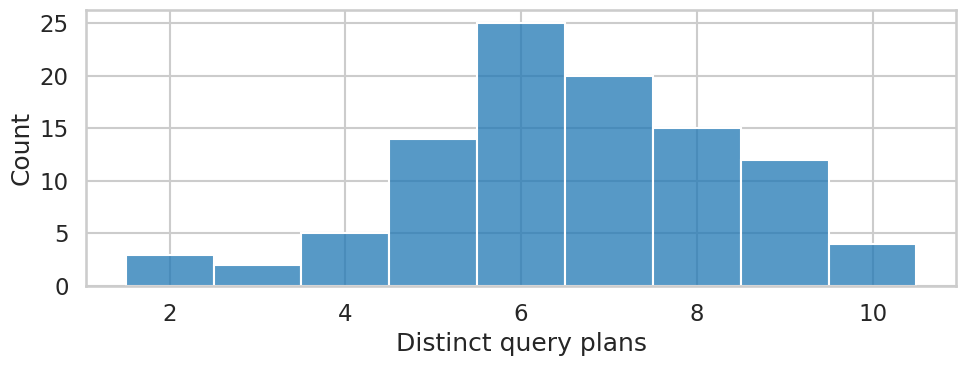

In [19]:
g = sns.histplot(stack_ppq.query("triggers_geqo & n_plans > 1"), x="n_plans", binwidth=1, discrete=True)
g.set(xlabel="Distinct query plans")
fig = g.get_figure()
fig.tight_layout()
fig.savefig("plots/stack-geqo-stability.pdf")

### Numbers used throughout the text

**Number of Stack queries that are optimized by GEQO:**

In [20]:
len([query for query in stack.queries() if len(query.tables()) >= 12])

100

**Number of GEQO queries that actually change their query plan at least once:**

In [21]:
stack_ppq.query("triggers_geqo & geqo == 'on' & n_plans > 1")["label"].count()

np.int64(100)

**Number of non-GEQO queries that still changed their execution plans at least once:**

In [22]:
stack_ppq.query("geqo == 'off' & n_plans > 1")["label"].count()

np.int64(36)

In [23]:
stack_ppq

,label,geqo,triggers_geqo,n_plans,min_rt,max_rt
0,q1/q1-001,off,False,1.0,0.602112,0.625653
1,q1/q1-002,off,False,1.0,0.573793,0.587325
2,q1/q1-003,off,False,1.0,0.573487,0.589956
3,q1/q1-004,off,False,1.0,0.573126,0.588807
4,q1/q1-005,off,False,1.0,0.573001,0.586721
...,...,...,...,...,...,...
6286,q16/fe18ef861ee217e2b76cc62067c9e8dd6d608685,off,False,1.0,1.588021,1.610373
6287,q16/fe278c80c8c1cce1a2b396888e297e0c43b6ac5a,off,False,1.0,1.593134,1.634819
6288,q16/ff788b5a7ca7f8c6644b4977c7a4556027d672f9,off,False,1.0,1.590746,1.614241
6289,q16/ffac1237b4c3729f268c466647072f3455b38919,off,False,1.0,1.590122,1.629222


**The queries affected by GEQO changes and by statistics changes are disjoint:**

In [24]:
def set_intersection(values: pd.Series) -> set:
    head, *tail = values.values
    reduced = head
    for elem in tail:
        reduced &= elem
    return reduced

(stack_ppq
 .query("n_plans > 1")
 .groupby(["geqo", "triggers_geqo"], as_index=False)#
 .agg(affected_queries=pd.NamedAgg(column="label", aggfunc=set))
 ["affected_queries"]
 .agg(set_intersection))

set()

### JOB data-shift

In [25]:
df_datashift = read_df(f"{results_base}/analyze-stability-job-datashift-vanilla.csv", job)

**Number of queries that change their execution plans during the data shift:**

In [26]:
datashift_ppq = (df_datashift
                 .groupby(["fill_factor", "label", "geqo"], as_index=False, observed=True)
                 .agg(n_plans=pd.NamedAgg(column="plan_hash", aggfunc=lambda plans: len(set(plans))))
                 .query("n_plans > 1"))
datashift_ppq.groupby(["fill_factor", "geqo"], as_index=False).agg(affected_queries=pd.NamedAgg(column="label", aggfunc="nunique"))

,fill_factor,geqo,affected_queries
0,0.05,off,2
1,0.10,off,3
2,0.25,off,4
3,0.50,off,4
4,0.75,off,5
5,1.00,off,25
